In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/MyDrive/PCB_defect_detection'

ModuleNotFoundError: No module named 'google'

In [ ]:
!pip install -U ultralytics



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 kB 14.3 MB/s eta 0:00:00 0:00:01





































  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)


  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)


  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)


  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)


  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)


  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)


  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)


  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)


  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

In [ ]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/PCB_USED

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/rotation

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/Annotations

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images/Missing_hole

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images/Short

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images/Open_circuit

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images/Spurious_copper

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images/Spur

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/images/Mouse_bite

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/rotation/Open_circuit_rotation

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/rotation/Spur_rotation

/content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/rotation/Spurious_copper_rotation

/content/drive/MyDrive/PCB_d

In [ ]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [ ]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations

Mouse_bite      	            115 images 	            115 annotations

Open_circuit    	            116 images 	            116 annotations

Short           	            116 images 	            116 annotations

Spur            	            115 images 	            115 annotations

Spurious_copper 	            116 images 	            116 annotations


# Create annotaton dataset

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [ ]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  01_open_circuit_01.jpg   3034    1586  open_circuit  1539  1149  1584  1205
1  01_open_circuit_01.jpg   3034    1586  open_circuit  1071  1342  1113  1380
2  01_open_circuit_01.jpg   3034    1586  open_circuit  1684   467  1727   503
3  01_open_circuit_02.jpg   3034    1586  open_circuit  1502  1349  1539  1378
4  01_open_circuit_02.jpg   3034    1586  open_circuit  1653  1196  1684  1229

# Visualization

In [ ]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [ ]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


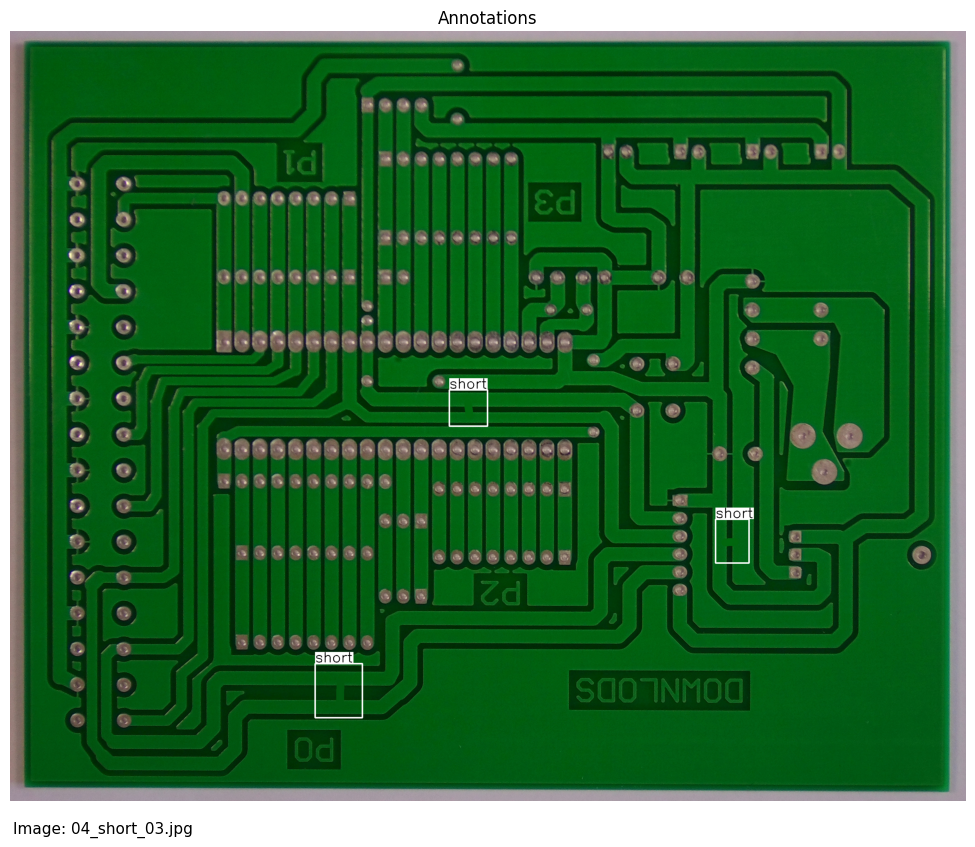

In [ ]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Dataset preprocessing

In [ ]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [ ]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  01_open_circuit_01.jpg    640     640  open_circuit   324   463   334   486
1  01_open_circuit_01.jpg    640     640  open_circuit   225   541   234   556
2  01_open_circuit_01.jpg    640     640  open_circuit   355   188   364   202
3  01_open_circuit_02.jpg    640     640  open_circuit   316   544   324   556
4  01_open_circuit_02.jpg    640     640  open_circuit   348   482   355   495

# Split dataset

In [ ]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [ ]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

# K-Fold Cross Validation

In [ ]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [ ]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [ ]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

0    1    2    3    4    5
01_missing_hole_01  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_02  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_03  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_04  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_05  4.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

0         1         2         3         4         5
split_1  0.375723  0.586441  0.284058      0.62  0.705455  0.415385
split_2  0.482866      0.56  0.506803  0.533123  0.324859  0.789883
split_3  0.670175  0.372434  0.793522  0.369014  0.517799  0.360947

In [ ]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [ ]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

# Model Training

In [ ]:
model = YOLO('yolov8s.pt')

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 180
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)

result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup)

New https://pypi.org/project/ultralytics/8.2.10 available 😃 Update with 'pip install -U ultralytics'

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_defect_detection/data.yaml, epochs=180, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas

train: Scanning /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/labels/train.cache... 658 images, 0 backgrounds, 0 corrupt: 100%|██████████| 658/658 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

val: Scanning /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/labels/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]


Plotting labels to pcb/train4/labels.jpg... 

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 

optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)

TensorBoard: model graph visualization added ✅

Image sizes 640 train, 640 val

Using 8 dataloader workers

Logging results to pcb/train4

Starting training for 180 epochs...



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180      4.15G      3.934      17.09      1.874         28        640: 100%|██████████| 42/42 [00:08<00:00,  5.00it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         34        148      0.837    0.00794    0.00241    0.00103




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180      3.97G      2.906      3.812      1.278          9        640: 100%|██████████| 42/42 [00:05<00:00,  8.07it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         34        148       0.31      0.278      0.192     0.0816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      3.91G      2.582      2.785      1.156         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.64it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         34        148      0.289      0.307       0.21     0.0872




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180      3.94G      2.485      2.409      1.136         25        640: 100%|██████████| 42/42 [00:04<00:00,  8.53it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.91it/s]

                   all         34        148      0.706       0.57      0.607      0.259




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180      3.98G      2.386      2.195      1.117         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.65it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

                   all         34        148      0.757      0.635      0.662      0.267




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      3.93G      2.258      1.909      1.093         11        640: 100%|██████████| 42/42 [00:04<00:00,  8.70it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         34        148      0.804      0.657      0.718      0.339




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      3.94G      2.212      1.815      1.076         16        640: 100%|██████████| 42/42 [00:04<00:00,  8.81it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.09it/s]

                   all         34        148      0.849      0.685      0.752      0.325




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      3.94G      2.226      1.823      1.079          4        640: 100%|██████████| 42/42 [00:04<00:00,  8.74it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

                   all         34        148      0.908      0.755      0.844      0.385




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180         4G      2.171       1.66      1.061         13        640: 100%|██████████| 42/42 [00:05<00:00,  7.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         34        148      0.859      0.767      0.827      0.419




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      3.94G      2.106      1.637      1.042         22        640: 100%|██████████| 42/42 [00:04<00:00,  8.71it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

                   all         34        148      0.873      0.745      0.782      0.379




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      3.93G      2.107      1.581      1.034          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.56it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         34        148        0.9      0.809      0.858      0.413




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      3.94G      2.066      1.587      1.041         13        640: 100%|██████████| 42/42 [00:04<00:00,  9.05it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         34        148      0.872      0.788      0.852      0.377




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      3.93G      2.141      1.604      1.047         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.50it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         34        148      0.877      0.803      0.869      0.388




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      3.93G       2.07      1.515      1.037         24        640: 100%|██████████| 42/42 [00:04<00:00,  8.89it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         34        148      0.901      0.775      0.879      0.413




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      3.93G      2.057      1.465       1.02         11        640: 100%|██████████| 42/42 [00:04<00:00,  8.66it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

                   all         34        148      0.848      0.802      0.854      0.416




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      3.94G      2.031      1.513      1.025          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

                   all         34        148      0.879      0.828      0.889      0.415




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      3.93G      1.991      1.436      1.009         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.85it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.47it/s]

                   all         34        148      0.944       0.81      0.881      0.426




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180      3.94G      2.014      1.433      1.016         20        640: 100%|██████████| 42/42 [00:04<00:00,  8.75it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]

                   all         34        148      0.845       0.85      0.876      0.434




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      3.94G      1.998      1.418      1.014          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.70it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

                   all         34        148      0.947      0.808      0.899      0.408




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180         4G      1.994      1.425      1.008         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.45it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]

                   all         34        148      0.912      0.856      0.896      0.454




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      3.98G       1.97       1.38      1.007          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.79it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         34        148      0.946      0.825      0.878      0.424




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180      3.94G      1.941      1.358      1.005         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.76it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

                   all         34        148      0.931      0.859      0.902      0.448




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      3.98G      1.957      1.362      1.003          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.70it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.36it/s]

                   all         34        148      0.928      0.858      0.905      0.482




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180      3.99G      2.003      1.403      1.002         23        640: 100%|██████████| 42/42 [00:04<00:00,  8.59it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]

                   all         34        148      0.934      0.841      0.886      0.408




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      3.93G      1.963      1.364      1.004          8        640: 100%|██████████| 42/42 [00:05<00:00,  8.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.51it/s]

                   all         34        148      0.942      0.864      0.925      0.446




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      3.94G      1.903      1.283      0.997         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.79it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         34        148      0.946      0.862      0.925      0.458




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      3.93G      1.943      1.366      1.006         23        640: 100%|██████████| 42/42 [00:04<00:00,  8.61it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

                   all         34        148      0.952      0.881      0.919      0.448




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      3.94G      1.941      1.342     0.9929          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.88it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         34        148      0.936      0.887       0.92      0.452




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      3.94G       1.93      1.308     0.9871         22        640: 100%|██████████| 42/42 [00:04<00:00,  8.58it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

                   all         34        148      0.943      0.886      0.928      0.467




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180      3.94G      1.935      1.325     0.9966         21        640: 100%|██████████| 42/42 [00:04<00:00,  8.84it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

                   all         34        148      0.942      0.839      0.916      0.465




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180      3.98G      1.919      1.284     0.9766         27        640: 100%|██████████| 42/42 [00:04<00:00,  8.66it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

                   all         34        148      0.954      0.837      0.919      0.474




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      3.93G      1.859      1.227     0.9762         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.78it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         34        148      0.941      0.845      0.917      0.458




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180      3.94G      1.887      1.282      0.981         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.84it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         34        148      0.948      0.842      0.914      0.463




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      3.99G      1.928      1.339      1.002         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.48it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         34        148      0.927      0.876      0.914      0.505




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      3.93G      1.862       1.24     0.9841          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         34        148      0.923      0.869       0.92      0.475




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180      3.94G      1.853       1.23     0.9783          5        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

                   all         34        148      0.953      0.869      0.914       0.49




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180      3.93G      1.829      1.184     0.9751          4        640: 100%|██████████| 42/42 [00:04<00:00,  8.89it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         34        148      0.922      0.884      0.926      0.484




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      3.94G      1.896      1.274     0.9758         37        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         34        148       0.92       0.89      0.935      0.493




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      3.93G      1.834       1.21     0.9611          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.52it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         34        148      0.978      0.858      0.938      0.474




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      3.94G      1.851      1.241      0.976          4        640: 100%|██████████| 42/42 [00:04<00:00,  8.81it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         34        148      0.967      0.833      0.924      0.477




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180         4G      1.861      1.239     0.9682         36        640: 100%|██████████| 42/42 [00:04<00:00,  8.49it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

                   all         34        148      0.926      0.907      0.936      0.467




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180      3.99G      1.856      1.213     0.9735         20        640: 100%|██████████| 42/42 [00:04<00:00,  8.92it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

                   all         34        148      0.932       0.89      0.936      0.495




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      3.93G      1.828      1.203     0.9697         30        640: 100%|██████████| 42/42 [00:05<00:00,  8.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         34        148      0.951      0.859      0.928      0.486




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      3.94G      1.857      1.224     0.9699         16        640: 100%|██████████| 42/42 [00:04<00:00,  8.82it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         34        148      0.979      0.875      0.923      0.473




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180      3.98G      1.822      1.137     0.9556         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.66it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]

                   all         34        148      0.954      0.885      0.915      0.484




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      3.94G       1.81      1.149     0.9541          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.92it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         34        148      0.961      0.883      0.927      0.477




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      3.93G       1.78      1.155     0.9516          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.61it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         34        148      0.956       0.85      0.943      0.495




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      3.99G       1.81      1.177     0.9638         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.50it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

                   all         34        148      0.947      0.901      0.938      0.477




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      3.93G      1.819      1.153     0.9622          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.58it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

                   all         34        148      0.956      0.862      0.926      0.475




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      3.93G      1.813      1.136      0.964         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.69it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

                   all         34        148      0.947      0.907      0.944      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      3.94G      1.802      1.178     0.9554         23        640: 100%|██████████| 42/42 [00:04<00:00,  8.68it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

                   all         34        148      0.941      0.886       0.94      0.495




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      3.94G      1.771      1.105     0.9558         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.51it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         34        148      0.954      0.916      0.947      0.482




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      3.98G      1.751      1.093     0.9461         16        640: 100%|██████████| 42/42 [00:04<00:00,  8.62it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]

                   all         34        148      0.946      0.906       0.94      0.463




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      3.99G      1.777       1.16     0.9539          5        640: 100%|██████████| 42/42 [00:04<00:00,  8.89it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

                   all         34        148      0.943      0.928      0.948      0.497




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      3.93G      1.805      1.178     0.9581         21        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

                   all         34        148      0.961      0.906      0.945       0.48




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      3.93G      1.797      1.137     0.9537         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.82it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

                   all         34        148      0.956      0.901      0.938      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      3.93G       1.77      1.097      0.952          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.46it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]

                   all         34        148      0.974      0.912      0.945      0.496




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      3.93G      1.737       1.09     0.9481         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]

                   all         34        148      0.971      0.874      0.936      0.489




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      3.99G      1.777      1.151     0.9509         20        640: 100%|██████████| 42/42 [00:04<00:00,  8.83it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

                   all         34        148      0.948      0.879      0.926      0.486




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180      3.98G      1.759      1.137     0.9467         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.54it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

                   all         34        148      0.957      0.892      0.948      0.493




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      3.93G      1.715      1.081     0.9425          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.63it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

                   all         34        148      0.968       0.91      0.949      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      3.94G      1.732      1.085     0.9467         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.70it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

                   all         34        148      0.963      0.887      0.948      0.491




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      3.93G      1.722      1.056     0.9467         13        640: 100%|██████████| 42/42 [00:04<00:00,  8.53it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

                   all         34        148      0.943      0.894      0.942      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      3.93G      1.745      1.079     0.9407          5        640: 100%|██████████| 42/42 [00:04<00:00,  8.48it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]

                   all         34        148       0.96      0.898      0.938      0.485




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      3.94G      1.736       1.08     0.9441          4        640: 100%|██████████| 42/42 [00:04<00:00,  8.63it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]

                   all         34        148      0.961      0.909       0.95      0.494




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      3.98G      1.732      1.082     0.9451         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.56it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         34        148      0.948       0.87      0.947      0.519




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      3.98G      1.757       1.11      0.955          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.84it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]

                   all         34        148      0.976      0.886      0.949      0.502




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180      3.94G      1.748      1.118     0.9416         25        640: 100%|██████████| 42/42 [00:04<00:00,  8.64it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]

                   all         34        148      0.956      0.904      0.945      0.498




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      3.94G      1.733      1.092     0.9406         13        640: 100%|██████████| 42/42 [00:04<00:00,  8.73it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]

                   all         34        148      0.955       0.92       0.95      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180         4G      1.704      1.031     0.9305          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.58it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

                   all         34        148      0.973      0.885      0.948      0.513




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      3.93G      1.706      1.063     0.9418          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]

                   all         34        148      0.958      0.894      0.944      0.511




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      3.93G      1.693      1.035     0.9394          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.71it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         34        148      0.963      0.909      0.948      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      3.93G      1.733      1.051     0.9365         29        640: 100%|██████████| 42/42 [00:04<00:00,  8.45it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]

                   all         34        148      0.966      0.911      0.952        0.5




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      3.98G      1.699      1.062     0.9359          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.73it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

                   all         34        148      0.962      0.913      0.951      0.498




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      3.93G      1.729       1.08     0.9463         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.68it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

                   all         34        148      0.963      0.895       0.94      0.488




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      3.94G      1.707      1.053     0.9434         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.61it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

                   all         34        148       0.96       0.91      0.946      0.491




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      3.98G      1.688      1.032     0.9321         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.66it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         34        148      0.962      0.915      0.943      0.489




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      3.94G      1.709      1.046     0.9377         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.60it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

                   all         34        148      0.956      0.866      0.942       0.51




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      3.98G      1.653      1.026     0.9217         25        640: 100%|██████████| 42/42 [00:04<00:00,  8.66it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

                   all         34        148      0.959      0.915      0.955      0.495




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      3.99G      1.677      1.018     0.9368          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.77it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]

                   all         34        148      0.961      0.916      0.952      0.482




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      3.93G       1.69      1.031      0.934         11        640: 100%|██████████| 42/42 [00:04<00:00,  8.73it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]

                   all         34        148      0.956      0.888      0.947      0.481




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180         4G      1.667     0.9891     0.9295         21        640: 100%|██████████| 42/42 [00:04<00:00,  8.60it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         34        148      0.968      0.887      0.936      0.482




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      3.93G      1.675      1.019     0.9433         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.69it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

                   all         34        148      0.963      0.919      0.956      0.509




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      3.94G      1.651      1.007     0.9328         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.76it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         34        148       0.95      0.909      0.948      0.486




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180      3.93G      1.672     0.9969     0.9247         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.48it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]

                   all         34        148      0.971      0.886      0.932       0.49




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180         4G      1.636     0.9616     0.9157          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.80it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


                   all         34        148      0.974      0.923      0.943       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      3.93G      1.621     0.9712     0.9273          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.47it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]

                   all         34        148      0.974      0.899      0.942      0.482




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180      3.94G      1.661      1.016     0.9275         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.68it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         34        148      0.953       0.92      0.954      0.514




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      3.99G      1.684      1.021     0.9293         11        640: 100%|██████████| 42/42 [00:04<00:00,  8.51it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

                   all         34        148      0.961      0.904      0.953      0.524




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      3.99G      1.648     0.9967     0.9223         10        640: 100%|██████████| 42/42 [00:05<00:00,  8.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]

                   all         34        148       0.96      0.908       0.95      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      3.94G       1.63     0.9855     0.9352          9        640: 100%|██████████| 42/42 [00:05<00:00,  8.17it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         34        148      0.956      0.909      0.945      0.505




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180      3.94G      1.642     0.9814     0.9255          8        640: 100%|██████████| 42/42 [00:05<00:00,  8.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

                   all         34        148      0.956      0.911      0.956      0.509




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      3.94G      1.615     0.9609     0.9236         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.47it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         34        148      0.944      0.924      0.956      0.511




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      3.94G      1.624     0.9727     0.9172          2        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

                   all         34        148      0.963      0.911      0.959        0.5




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      3.94G      1.638     0.9586     0.9185         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.74it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         34        148      0.961      0.918      0.937      0.506




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      3.98G       1.63     0.9723      0.925         26        640: 100%|██████████| 42/42 [00:04<00:00,  8.56it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]

                   all         34        148      0.969      0.903      0.934      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      3.93G      1.643     0.9729     0.9264          3        640: 100%|██████████| 42/42 [00:04<00:00,  8.77it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         34        148      0.984      0.901      0.936      0.502




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      3.99G      1.621     0.9659     0.9141         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.68it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         34        148      0.978      0.904      0.942      0.482




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      3.98G      1.615     0.9996     0.9246          6        640: 100%|██████████| 42/42 [00:04<00:00,  9.06it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]

                   all         34        148      0.953      0.924      0.946      0.502




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      3.98G      1.609     0.9816     0.9189         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.71it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         34        148      0.971      0.914      0.955      0.497




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      3.98G      1.595     0.9287     0.9129         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]

                   all         34        148      0.953       0.93      0.961      0.503




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      3.94G      1.617     0.9583     0.9156         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.60it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]

                   all         34        148      0.969      0.903      0.948      0.491




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      3.93G       1.59     0.9538     0.9116          5        640: 100%|██████████| 42/42 [00:04<00:00,  8.51it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

                   all         34        148       0.98      0.924       0.96      0.502




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      3.94G      1.595     0.9655     0.9167         11        640: 100%|██████████| 42/42 [00:04<00:00,  8.72it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         34        148      0.972      0.916      0.956      0.489




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180         4G      1.615     0.9838     0.9179         26        640: 100%|██████████| 42/42 [00:04<00:00,  8.45it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         34        148      0.961      0.911      0.943      0.485




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      3.94G      1.604     0.9606     0.9193          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.90it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         34        148      0.983      0.907      0.958      0.509




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      3.98G      1.596     0.9658     0.9156          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.62it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         34        148      0.977      0.905      0.953      0.517




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      3.94G      1.584     0.9558     0.9181          5        640: 100%|██████████| 42/42 [00:04<00:00,  8.76it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

                   all         34        148      0.974      0.913      0.955       0.49




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      3.99G      1.565      0.908     0.9177         14        640: 100%|██████████| 42/42 [00:04<00:00,  9.02it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

                   all         34        148      0.968      0.892      0.934      0.509




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      3.93G      1.568     0.9409     0.9183         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.62it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]

                   all         34        148      0.981      0.918      0.946      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      3.93G      1.535     0.9135     0.9043          4        640: 100%|██████████| 42/42 [00:04<00:00,  8.83it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]

                   all         34        148       0.98      0.912      0.955      0.522




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      3.93G      1.565      0.904      0.909         20        640: 100%|██████████| 42/42 [00:04<00:00,  8.61it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         34        148      0.965      0.912      0.956      0.507




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      3.94G      1.536     0.9254     0.9078         22        640: 100%|██████████| 42/42 [00:04<00:00,  8.91it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]

                   all         34        148      0.976      0.919      0.957      0.491




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      3.93G      1.566     0.9216     0.9144         21        640: 100%|██████████| 42/42 [00:04<00:00,  9.14it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         34        148      0.981      0.916       0.96      0.507




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      3.93G      1.549     0.9234     0.9071         30        640: 100%|██████████| 42/42 [00:04<00:00,  8.50it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

                   all         34        148      0.973      0.924      0.959      0.511




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      3.94G       1.54     0.9105     0.9172         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.70it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

                   all         34        148      0.976      0.909       0.96      0.505




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      3.99G      1.559     0.9374     0.9094         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         34        148      0.972      0.928      0.967      0.536




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      3.94G      1.538     0.9049     0.9099         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.88it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

                   all         34        148      0.977      0.919      0.957      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      3.98G      1.549     0.9151     0.9085         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         34        148      0.975      0.916      0.962      0.526




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180         4G      1.532     0.9064     0.9174          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.77it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         34        148      0.975      0.933      0.961      0.505




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      3.93G      1.549     0.9296     0.9119         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.47it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         34        148      0.961      0.913      0.954      0.506




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      3.94G      1.536     0.9005     0.9121         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.62it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

                   all         34        148      0.968      0.908      0.958      0.508




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      3.98G      1.526     0.9112     0.9015         13        640: 100%|██████████| 42/42 [00:04<00:00,  8.77it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

                   all         34        148      0.965      0.916      0.961      0.506




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      3.98G      1.518     0.8893     0.9047         23        640: 100%|██████████| 42/42 [00:04<00:00,  8.86it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         34        148       0.96      0.933      0.958      0.498




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      3.94G      1.515     0.8701     0.8941         28        640: 100%|██████████| 42/42 [00:04<00:00,  8.72it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         34        148      0.966      0.913      0.957      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      3.94G      1.534      0.905     0.9022         13        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         34        148      0.978      0.923      0.958      0.506




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      3.93G      1.508     0.8939     0.9014         22        640: 100%|██████████| 42/42 [00:04<00:00,  8.88it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         34        148      0.965      0.924      0.958      0.513




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      3.94G      1.526     0.8885     0.9112         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.61it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         34        148      0.948      0.924      0.954      0.496




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      3.98G      1.473     0.8566     0.8947         19        640: 100%|██████████| 42/42 [00:04<00:00,  9.05it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         34        148      0.977       0.92      0.953      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      3.98G      1.455     0.8479     0.8965          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.81it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         34        148       0.98      0.921      0.955       0.51




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      3.98G      1.512     0.9107     0.9003          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.65it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         34        148      0.979      0.924      0.959      0.511




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      3.99G      1.513     0.8953     0.8985         24        640: 100%|██████████| 42/42 [00:04<00:00,  8.79it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         34        148      0.969      0.931      0.956      0.508




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      3.99G      1.473     0.8475      0.898          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.62it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]

                   all         34        148      0.979      0.922      0.957      0.516




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      3.94G      1.459     0.8686     0.8946         16        640: 100%|██████████| 42/42 [00:04<00:00,  9.13it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         34        148      0.983      0.924      0.958      0.508




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      3.93G      1.456     0.8551     0.8889         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.46it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

                   all         34        148      0.969       0.91      0.958      0.516




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      3.93G      1.488     0.8694     0.8978         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.65it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         34        148      0.969      0.923      0.956      0.496




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      3.93G      1.463     0.8461      0.893         13        640: 100%|██████████| 42/42 [00:04<00:00,  8.76it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         34        148       0.98      0.913      0.954      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      3.94G      1.455     0.8569     0.8942         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.72it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

                   all         34        148      0.962      0.877      0.955      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180      3.93G      1.471     0.8794     0.8982         10        640: 100%|██████████| 42/42 [00:05<00:00,  8.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

                   all         34        148      0.952      0.881      0.956      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      3.94G      1.422     0.8139     0.8889         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

                   all         34        148      0.977      0.915      0.964      0.508




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180         4G       1.45     0.8542      0.893         20        640: 100%|██████████| 42/42 [00:04<00:00,  8.46it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

                   all         34        148      0.976       0.91      0.953      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180      3.94G      1.444     0.8382     0.8974         19        640: 100%|██████████| 42/42 [00:04<00:00,  8.51it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         34        148      0.962      0.902      0.949      0.496




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      3.97G      1.466     0.8533     0.9022         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.73it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         34        148      0.976      0.931      0.961      0.484




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      3.94G      1.451      0.852     0.8864         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.87it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

                   all         34        148      0.981      0.932      0.967      0.484




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      3.93G      1.396      0.801     0.8861         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.80it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]

                   all         34        148      0.983      0.922      0.967      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      3.94G      1.456     0.8352     0.9015         12        640: 100%|██████████| 42/42 [00:04<00:00,  8.71it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

                   all         34        148      0.982      0.903       0.96      0.486




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      3.94G      1.432     0.8639     0.8973         26        640: 100%|██████████| 42/42 [00:04<00:00,  8.60it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]

                   all         34        148      0.982      0.919      0.963      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      3.94G      1.397     0.8291     0.8891          5        640: 100%|██████████| 42/42 [00:04<00:00,  8.73it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

                   all         34        148      0.977      0.915      0.962      0.507




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      3.97G      1.415     0.8302     0.8861         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.80it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         34        148       0.98      0.918      0.965      0.509




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      3.98G      1.404     0.8348     0.8846         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.74it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         34        148      0.984      0.922      0.958      0.493




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      3.99G      1.429     0.8378     0.8862         29        640: 100%|██████████| 42/42 [00:04<00:00,  8.64it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.93it/s]

                   all         34        148      0.983      0.916       0.96      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      3.94G       1.41     0.8278     0.8855         13        640: 100%|██████████| 42/42 [00:04<00:00,  8.79it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         34        148      0.986      0.915      0.963      0.503




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      3.93G      1.428     0.8397     0.8918         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.72it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

                   all         34        148      0.967      0.934      0.966      0.514




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180      3.94G      1.406     0.8238     0.8931         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.70it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

                   all         34        148      0.979      0.925      0.963      0.506




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      3.98G      1.406     0.8399     0.8881         42        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]

                   all         34        148      0.981      0.927      0.967      0.519




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180      3.94G      1.409     0.8319     0.8887         30        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         34        148      0.967      0.913      0.959       0.52




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      3.93G       1.38     0.7993     0.8919         11        640: 100%|██████████| 42/42 [00:04<00:00,  8.88it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]

                   all         34        148      0.981      0.919      0.964       0.51




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      3.99G      1.397     0.8255     0.8891         34        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

                   all         34        148      0.983      0.924      0.965      0.507




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      3.99G      1.417     0.8221      0.898         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.94it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

                   all         34        148      0.972      0.915      0.963      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180         4G      1.385     0.8139     0.8857         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.59it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]

                   all         34        148      0.976      0.909       0.96      0.497




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      3.94G      1.364     0.7891      0.882          6        640: 100%|██████████| 42/42 [00:04<00:00,  8.76it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         34        148      0.979      0.918      0.966      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      3.94G      1.409     0.8243     0.8865         21        640: 100%|██████████| 42/42 [00:04<00:00,  8.77it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

                   all         34        148       0.97      0.914      0.966        0.5




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      3.98G      1.417      0.831     0.8857         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.57it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         34        148      0.971      0.916       0.96      0.502




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      3.93G      1.347      0.772     0.8831         18        640: 100%|██████████| 42/42 [00:04<00:00,  8.99it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

                   all         34        148      0.986       0.92      0.964      0.501




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      3.99G      1.373     0.7875     0.8758         17        640: 100%|██████████| 42/42 [00:04<00:00,  8.56it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

                   all         34        148      0.981      0.919      0.962      0.505




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      3.98G      1.364      0.801     0.8835         14        640: 100%|██████████| 42/42 [00:04<00:00,  8.85it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]

                   all         34        148       0.98      0.919      0.965      0.507




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      3.94G      1.373     0.8019     0.8785         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.69it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         34        148      0.984      0.917      0.968      0.502




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      3.94G      1.329     0.7559     0.8776         15        640: 100%|██████████| 42/42 [00:04<00:00,  8.78it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         34        148      0.978      0.921      0.968        0.5




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      3.93G      1.354      0.783     0.8816          7        640: 100%|██████████| 42/42 [00:04<00:00,  8.49it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

                   all         34        148      0.982      0.919      0.968      0.505




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      3.98G      1.356      0.797     0.8949          9        640: 100%|██████████| 42/42 [00:04<00:00,  8.52it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

                   all         34        148      0.975      0.922      0.967        0.5


Closing dataloader mosaic

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180      3.93G      1.154     0.5506     0.8636          6        640: 100%|██████████| 42/42 [00:06<00:00,  6.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         34        148      0.975      0.923      0.959      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180      3.94G       1.13     0.5333     0.8513          8        640: 100%|██████████| 42/42 [00:04<00:00,  9.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         34        148      0.968      0.924      0.953      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180      3.93G      1.119     0.5242     0.8604          8        640: 100%|██████████| 42/42 [00:04<00:00,  9.51it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         34        148      0.968      0.925      0.954      0.485




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180      3.93G      1.121     0.5352     0.8552         10        640: 100%|██████████| 42/42 [00:04<00:00,  9.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         34        148      0.975      0.911      0.952      0.488




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180      3.93G      1.106     0.5253     0.8553         10        640: 100%|██████████| 42/42 [00:04<00:00,  9.11it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         34        148      0.965      0.919      0.953      0.488




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180      3.94G      1.092     0.5321      0.852         10        640: 100%|██████████| 42/42 [00:04<00:00,  9.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]

                   all         34        148       0.96      0.914      0.953      0.486




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180      3.93G      1.087     0.5118     0.8486          8        640: 100%|██████████| 42/42 [00:04<00:00,  9.01it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


                   all         34        148      0.961      0.918      0.953      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180      3.93G      1.066     0.5107      0.847          6        640: 100%|██████████| 42/42 [00:04<00:00,  9.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

                   all         34        148      0.963      0.918      0.953      0.492




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180      3.93G      1.086     0.5104     0.8485          8        640: 100%|██████████| 42/42 [00:04<00:00,  8.67it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

                   all         34        148      0.969      0.926      0.957      0.494




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180      3.94G       1.09      0.525     0.8567         10        640: 100%|██████████| 42/42 [00:04<00:00,  8.91it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]

                   all         34        148      0.968      0.926      0.956      0.491




180 epochs completed in 0.313 hours.

Optimizer stripped from pcb/train4/weights/last.pt, 22.5MB

Optimizer stripped from pcb/train4/weights/best.pt, 22.5MB



Validating pcb/train4/weights/best.pt...

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


                   all         34        148      0.972      0.929      0.967      0.532

          missing_hole         34         21       0.97          1      0.995      0.559

            mouse_bite         34         24          1      0.827      0.958      0.413

          open_circuit         34         36      0.988      0.889      0.966      0.504

                 short         34          5      0.922          1      0.995      0.704

                  spur         34         19          1      0.861      0.899      0.492

       spurious_copper         34         43      0.955      0.996       0.99      0.522

Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image

Results saved to pcb/train4


In [ ]:
results_dir = '/content/pcb/train4'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

'/content/drive/MyDrive/PCB_defect_detection/results'

In [ ]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

epoch  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1          3.9341         17.0870          1.8742   
2      3          2.5819          2.7850          1.1556   
3      4          2.4854          2.4089          1.1356   
4      5          2.3862          2.1951          1.1174   
5      6          2.2584          1.9089          1.0930   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.83743            0.00794           0.00241   
2               0.28893            0.30746           0.21031   
3               0.70614            0.56951           0.60665   
4               0.75729            0.63467           0.66181   
5               0.80447            0.65658           0.71811   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00103        2.7993        7.4172        1.3426  0.000325   
2              0.08724        2.5555       34.8800        1.2254  0.000981   
3              0.25857        2.1330        1.8328        1.0882  0.000983   
4              0.26658        2.0286        1.2889        1.1183  0.000978   
5              0.33907        1.9116        1.3760        1.0565  0.000972   

     lr/pg1    lr/pg2  
0  0.000325  0.000325  
2  0.000981  0.000981  
3  0.000983  0.000983  
4  0.000978  0.000978  
5  0.000972  0.000972

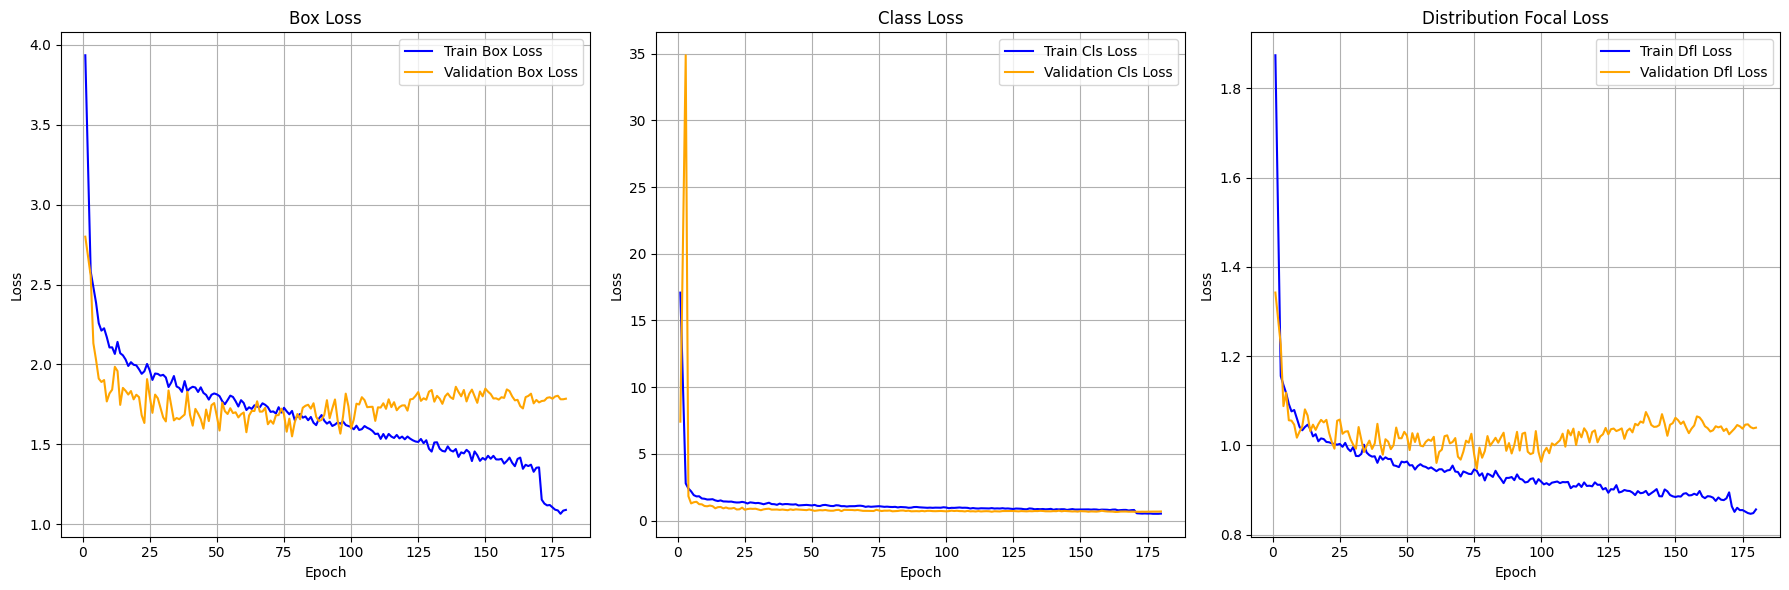

In [ ]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Predict on test data

In [ ]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)



image 1/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_missing_hole_07.jpg: 640x640 3 missing_holes, 10.4ms

image 2/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_missing_hole_12.jpg: 640x640 3 missing_holes, 11.1ms

image 3/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_mouse_bite_09.jpg: 640x640 1 mouse_bite, 10.6ms

image 4/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_mouse_bite_16.jpg: 640x640 1 mouse_bite, 10.6ms

image 5/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_open_circuit_11.jpg: 640x640 2 open_circuits, 11.1ms

image 6/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_open_circuit_13.jpg: 640x640 1 open_circuit, 11.3ms

image 7/34 /content/drive/MyDrive/PCB_defect_detection/PCB_DATASET/output/images/val/01_spur_08.jpg: 640x640 1 spur, 11.4ms

image 8/34 /content/drive/MyDriv

In [ ]:
predict_dir = '/content/runs/detect/predict'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

'/content/drive/MyDrive/PCB_defect_detection/results/predict'

In [ ]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [ ]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(dest_predict_dir, 'labels/12_spurious_copper_10.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[5.0, 0.715496, 0.149549, 0.0180754, 0.035031, 0.777879],
 [5.0, 0.564905, 0.38149, 0.028614, 0.0293633, 0.746318],
 [5.0, 0.444732, 0.741324, 0.0413345, 0.0171911, 0.740022],
 [5.0, 0.733858, 0.586022, 0.0178168, 0.0366995, 0.73277],
 [5.0, 0.140921, 0.654838, 0.0336746, 0.0197135, 0.686157]]

In [ ]:
pred_annot_df = yolo_to_original_annot('12_spurious_copper_10.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

filename  width  height            class  xmin  ymin  \
0  12_spurious_copper_10.jpg   2529    2530  spurious_copper  1786   334   
1  12_spurious_copper_10.jpg   2529    2530  spurious_copper  1392   928   
2  12_spurious_copper_10.jpg   2529    2530  spurious_copper  1072  1853   
3  12_spurious_copper_10.jpg   2529    2530  spurious_copper  1833  1436   
4  12_spurious_copper_10.jpg   2529    2530  spurious_copper   313  1631   

   xmax  ymax  confidence  
0  1832   422    0.777879  
1  1464  1002    0.746318  
2  1176  1897    0.740022  
3  1878  1529    0.732770  
4   398  1681    0.686157

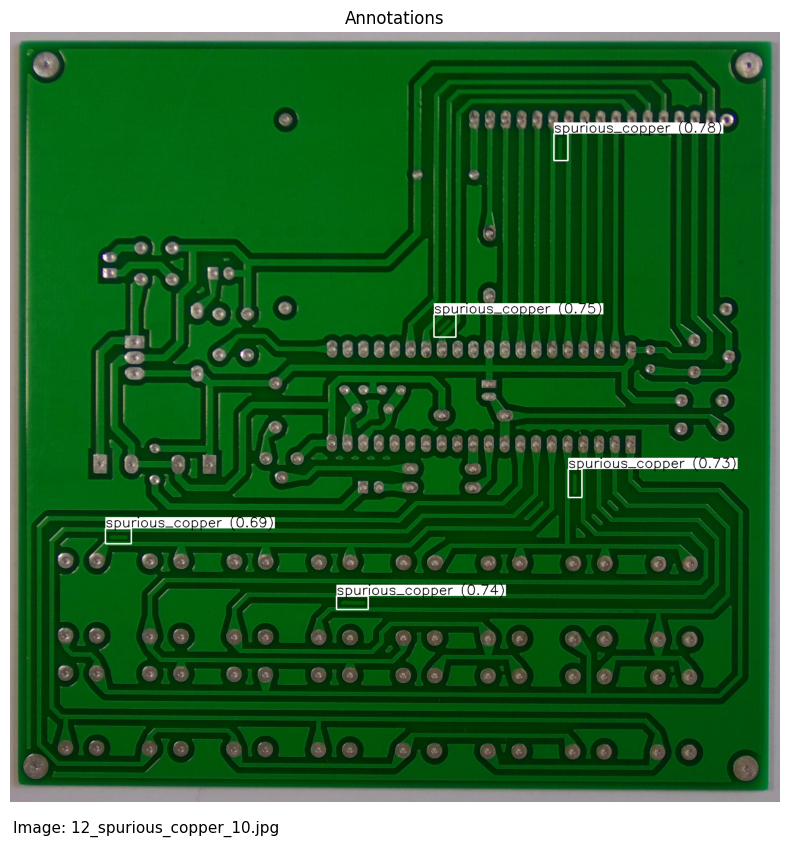

In [ ]:
visualize_annotations('12_spurious_copper_10.jpg', images_dir, pred_annot_df, is_subfolder=True);

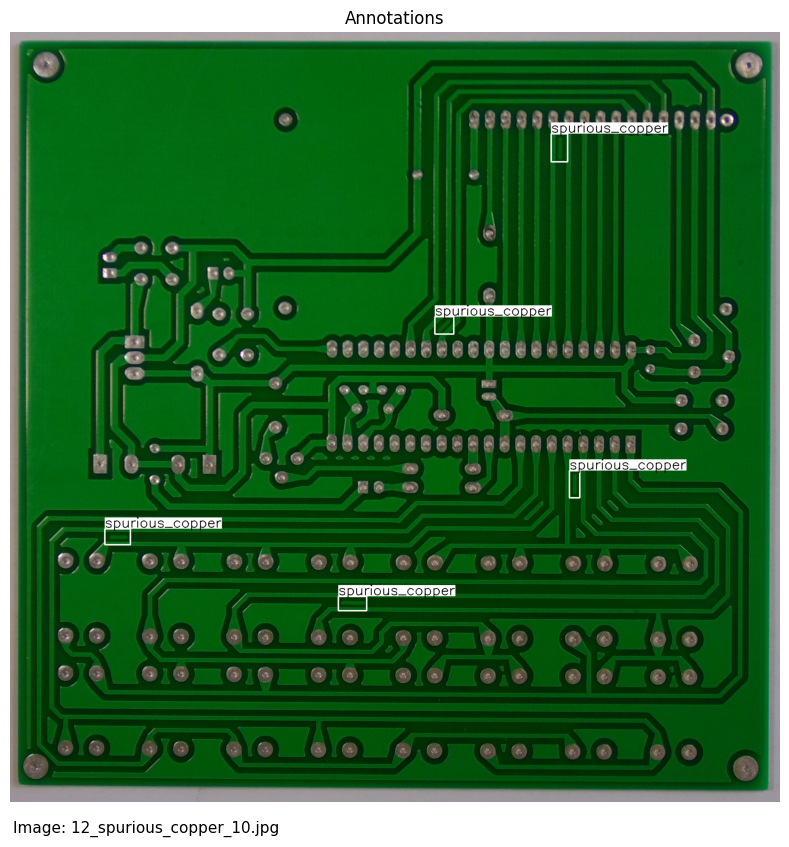

In [ ]:
visualize_annotations('12_spurious_copper_10.jpg', images_dir, annot_df, is_subfolder=True);

In [ ]:
model.export()

Ultralytics YOLOv8.2.9 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)



PyTorch: starting from '/content/drive/MyDrive/PCB_defect_detection/results/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)



TorchScript: starting export with torch 2.2.1+cu121...

TorchScript: export success ✅ 2.0s, saved as '/content/drive/MyDrive/PCB_defect_detection/results/weights/best.torchscript' (42.9 MB)



Export complete (3.5s)

Results saved to /content/drive/MyDrive/PCB_defect_detection/results/weights

Predict:         yolo predict task=detect model=/content/drive/MyDrive/PCB_defect_detection/results/weights/best.torchscript imgsz=640  

Validate:        yolo val task=detect model=/content/drive/MyDrive/PCB_defect_detection/results/weights/best.torchscript imgsz=640 data=/content/drive/MyDrive/PCB_defect_detection/data.yaml  

Visualize:       https://netron.app


'/content/drive/MyDrive/PCB_defect_detection/results/weights/best.torchscript'

In [ ]:
custom_img_dir = os.path.join(root_dir, 'custom_images')
resized_custom_img_dir = os.path.join(custom_img_dir, 'resized')
resize_images(custom_img_dir, resized_custom_img_dir)

In [ ]:
model = YOLO(best_model_path)

image_path = os.path.join(resized_custom_img_dir, '01.jpg')
result_custom = model(image_path, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)



image 1/1 /content/drive/MyDrive/PCB_defect_detection/custom_images/resized/01.jpg: 640x640 1 missing_hole, 1 open_circuit, 1 spurious_copper, 10.8ms

Speed: 1.6ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

Results saved to runs/detect/predict2

1 label saved to runs/detect/predict2/labels


In [ ]:
predict_dir = '/content/runs/detect/predict2'
dest_custom_predict_dir = os.path.join(custom_img_dir, 'results/predict')

shutil.copytree(predict_dir, dest_custom_predict_dir)

'/content/drive/MyDrive/PCB_defect_detection/custom_images/results/predict'